# OCAI

OCAI (Open and Close Artifical Intelligence) is a statistic machine learning model used to predict whether the following day will be higher or lower than the previous. This basic stock prediction model can provided short-term insights into data for investors.

More specifically, OCAI answers the classification-based question, "Given N number of consecutive days' stock prices, will the next day be higher or lower than the day before it?" This Jupyter Notebook describes and visualizes the thought process behind selecting the best model and hyperparameters among linear regression, logistic regression, random forests, and decision trees.

In [42]:
# all imports and constants
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from math import sqrt
import statsmodels.api as sm

## 1. Data Handling and Displaying

The data starts as a large CSV of stock prices, where each day has several statistics. Since the goal is a simple stock predictor, only the average of the open and close price will be used to limit each day to two variables: the date and the stock price. An average of the open and close price also helps in reducing random sub-day spikes in stock price. However, the models tested in this study will require that the dates also be a singular number; the Julian Day calendar fits this description.

The first, jagged graph is the raw result of the data selection described above. The following two graphs of data will be used later to stress-test the models used in this study.

**Task:**

1. Read Birkshire Hathaway CSV file
2. Cure the Data
    - Convert time format to Julian
    - Add a "Mid" feature that averages the open and close prices
    - Drop "Open" and "Close" features
3. Display Data
    - Print number of days of data
    - Print the data header before and after curing
    - Plot "Mid" the mid feature over julian time

Number of entries: 2408


Raw data:
         Date        Open       Close
0  2015-01-02  151.500000  149.169998
1  2015-01-05  148.809998  147.000000
2  2015-01-06  147.639999  146.839996
3  2015-01-07  147.940002  148.880005
4  2015-01-08  150.600006  151.369995


After curating data:
      Date         Mid
0  2457024  150.334999
1  2457027  147.904999
2  2457028  147.239998
3  2457029  148.410004
4  2457030  150.985001


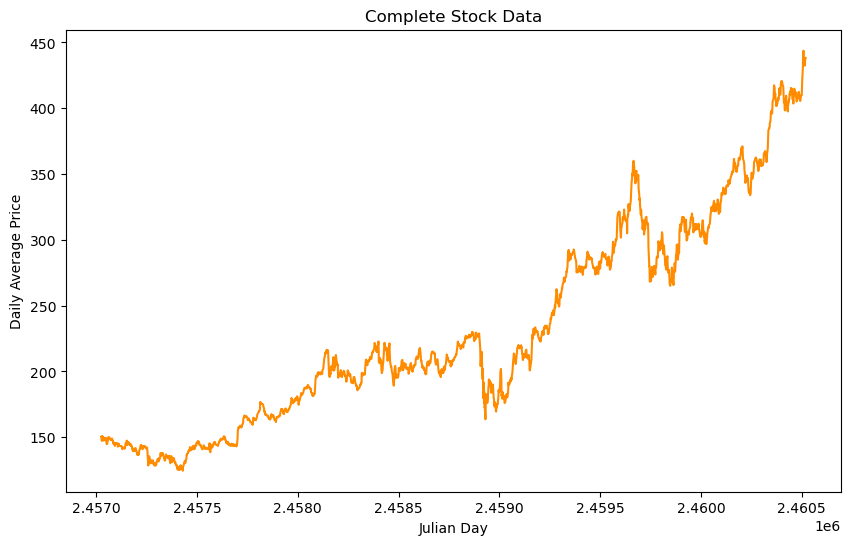

In [43]:
# 1.1 Read Birkshire Hathaway CSV file
# Data pulled from https://www.kaggle.com/datasets/umerhaddii/berkshire-hathaway-stock-price-data
# Using the data curation from https://github.com/hemangjoshi37a/TrendMaster/blob/main/trendmaster/data_loader.py
firstDF = pd.read_csv('stocks.csv')[['Date', 'Open', 'Close']]
print("Number of entries:", len(firstDF['Date'].values))
print("\n\nRaw data:")
print(firstDF.head(5))

# 1.2 Cure data
# Get Julian day and average the open and close values for the day as a new feature, "Mid"
firstDF['Date'] = firstDF['Date'].apply(lambda x: pd.to_datetime(x).to_julian_date().astype(int))
firstDF['Mid'] = (firstDF['Open'] + firstDF['Close']) / 2
firstDF = firstDF.drop(columns=['Open', 'Close'])
print("\n\nAfter curating data:")
print(firstDF.head(5))

# 1.3 Display Data
# Get arrays of dates and stock prices
dates = firstDF['Date'].values
prices = firstDF['Mid'].values

# Display data
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, color="darkorange")
plt.title("Complete Stock Data")
plt.xlabel("Julian Day")
plt.ylabel("Daily Average Price")
plt.show()

## 2. Creating The Feature Space and Labels

While the sequential stock price data has been created, the models of this study require the data be curated further into a specific format. Namely, there must be two arrays:
- The first, `X`, will be a 2D array. Each entry in this array will store N number of days for the model to predict with. No day is reused in this array; every feature represents a unique day.
- The second, `y`, will be a 1D array. If the first entry in `X` is the first N days of the stock price data, the first entry in `y` will state whether day N+1 has a higher stock price than day N. As such, both `X` and `y` are linked so that they have the same length and any index corresponds to the same sample in either array.

The function `createXY` takes in three parameters as seen below:
- `prices` is the modified stock data the models will use to make predictions. This provides the information necessary for `X`.
- `real_prices` is the <i>real</i> stock data that is used to verify whether the model prediction is correct. While this argument could be hardcoded as the raw data read earlier, keeping it as a parameter allows for more freedom in testing the models of this study. This parameter allows the program to create `y`.

**Task:**

1. Create the empty data arrays
2. Section off data into the appropriate index



In [44]:
def createXY(prices: np.ndarray, real_prices: np.ndarray, sampleSize: int) -> tuple[np.ndarray, np.ndarray]:
    # 2.1 Create the empty data arrays
    numSamples = int(len(prices) / (sampleSize + 1))
    X = np.full((numSamples, sampleSize), np.nan)
    y = np.full((numSamples), np.nan)

    # 2.2 Section off data into the appropriate index
    for i in range(0, numSamples):
        start = i * (sampleSize + 1)
        X[i] = (prices[start : start + sampleSize])
        y[i] = (int(real_prices[start + sampleSize] > real_prices[start + sampleSize - 1]))
    
    return X, y

## 3. Evaluating Models

This classification problem pits four different models against each other to determine the best one: linear regression, logistic regression, random forests, and decision trees. Each model is put into a k-fold cross validation algorithm to its robust accuracy evaluation.

However, linear regression is hardly considered a classification-based model. In its pure form, a linear regression model cannot make a binary classification from a single, high-dimensional point. To convert it to fit this study's problem, each feature of the sample reverts back into the original 2D date-price format. For example, if each sample had five days to predict a sixth day, the array `[1, 2, 3, 4, 5]` would be put alongside feature array to create a suitable context to make determine a linear regression line of best fit. If the slope of the line is positive, then the model has 'predicted' the sixth day will have a greater stock price than the fifth day. Since this arbitrary model format does not need any form of training, its evaluation does not require a k-fold cross validation. Instead, all of the samples are used to evaluate the linear regression model.

There are two functions in the code block below:
- The `predict_linReg` function implements this unique version of linear regression.
- `eval_models` is the higher-level function which determines the accuracy values of each fold for each traditional classification model. Since there are three of these models, three arrays of accuracies are returned from the function. The performance of the linear regression model is only represented with its singular accuracy value.

**Task:**

1. Determine the classification of the linear regression model
2. Create the traditional classification models
3. Evaluate each model with k-fold cross validation or otherwise

In [45]:
def predict_linReg(X_test: np.ndarray) -> np.ndarray:
    # 3.1 Determine the classification of the linear regression model
    model = LinearRegression()
    pred = np.full((X_test.shape[0]), np.nan)
    days = np.linspace(0, X_test.shape[1] - 1, X_test.shape[1], dtype=int)
    for i in range(X_test.shape[0]):
        model.fit(days.reshape(-1, 1), X_test[i].flatten())
        pred[i] = int(model.coef_[0] > 0)
    return pred


def eval_models(prices: np.ndarray, real_prices: np.ndarray, sampleSize: int, numSplits: int, random_state: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    # 3.2 Create the traditional classification models
    clf = DecisionTreeClassifier(random_state=random_state)
    forest = RandomForestClassifier(max_depth=2, random_state=random_state)
    logReg = LogisticRegression(random_state=random_state)

    # 3.3 Evaluate each model with k-fold cross validation or otherwise
    X, y = createXY(prices, real_prices, sampleSize)
    stats_clf = cross_val_score(clf, X, y, scoring='accuracy', cv=KFold(n_splits=numSplits), n_jobs=-1)
    stats_forest = cross_val_score(forest, X, y, scoring='accuracy', cv=KFold(n_splits=numSplits), n_jobs=-1)
    stats_logReg = cross_val_score(logReg, X, y, scoring='accuracy', cv=KFold(n_splits=numSplits), n_jobs=-1)
    acc_linReg = accuracy_score(y, predict_linReg(X))

    return stats_clf, stats_forest, stats_logReg, acc_linReg

## Grid Optimization

While sample format works, the number of days models should predict with must be chosen. While this could be done arbitrarily, a grid optimization can be used to find the optimal sample size.

The `grid_optim` function takes in the extracted data to populate the `X` array and the `real_prices` to populate the `y` array. For each sample size tested, the four models are evaluated. The best performance is tracked until the end of the program, and the results are displayed in a graph. The average performance across all sample sizes are also determined for each model.

**Task:**

<ol>
    <li>Define hyperparameters</li>
    <li>Iterate through each sample size</li>
    <ol>
        <li>Evaluate each model</li>
        <li>Update the best performance</li>
        <li>Add to list of sample size accuracies</li>
    </ol>
    <li>Print best accuracy and model</li>
    <li>Plot accuracies for each iteration</li>
</ol>

Best accuracy: Linear Regression at 0.742 with standard deviation of -1.000 and sample size of 76
Average performances:

	Decision Tree: 0.4838964878489522
	Random Forest: 0.48276081483848926
	Logistic Regression: 0.5017159364961332
	Linear Regression: 0.5302919350729622


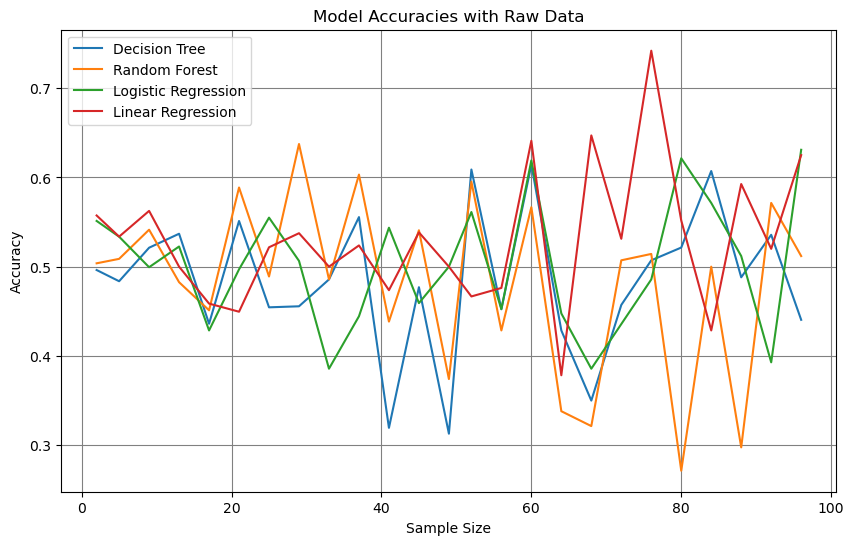

In [46]:
def grid_optim(prices: np.ndarray, real_prices: np.ndarray, plot_title: str):
    # 3.1 Define hyperparameters
    RANDOM_STATE = 42
    NUM_ITERATIONS = 25
    MAX_SAMPLESIZE = 100
    NUM_SPLITS = 7

    # 3.2 Iterate through each sample size
    best_model = ""
    max_acc = -1
    max_std = -1
    max_size = -1
    final_accs = [[], [], [], []]
    sampleSizes = []
    for i in range(NUM_ITERATIONS):
        sampleSize = int(i * (MAX_SAMPLESIZE - 2) / NUM_ITERATIONS + 2)

        # 3.2.1 Evaluate each model
        stats_clf, stats_forest, stats_logReg, acc_linReg = eval_models(prices, real_prices, sampleSize, NUM_SPLITS, RANDOM_STATE)

        # 3.2.2 Update the best performance
        if stats_clf.mean() > max_acc:
            best_model = "Decision Tree"
            max_acc = stats_clf.mean()
            max_std = stats_clf.std()
            max_size = sampleSize
        if stats_forest.mean() > max_acc:
            best_model = "Random Forest"
            max_acc = stats_forest.mean()
            max_std = stats_forest.std()
            max_size = sampleSize
        if stats_logReg.mean() > max_acc:
            best_model = "Logistic Regression"
            max_acc = stats_logReg.mean()
            max_std = stats_logReg.std()
            max_size = sampleSize
        if acc_linReg > max_acc:
            best_model = "Linear Regression"
            max_acc = acc_linReg
            max_std = -1
            max_size = sampleSize

        # 3.2.3 Add to list of sample size accuracies
        final_accs[0].append(stats_clf.mean())
        final_accs[1].append(stats_forest.mean())
        final_accs[2].append(stats_logReg.mean())
        final_accs[3].append(acc_linReg)
        sampleSizes.append(sampleSize)

    # 3.3 Print best accuracy and model
    print(f"Best accuracy: {best_model} at {max_acc:.3f} with standard deviation of {max_std:.3f} and sample size of {max_size}")
    print("Average performances:\n")
    print(f"\tDecision Tree: {np.mean(final_accs[0])}")
    print(f"\tRandom Forest: {np.mean(final_accs[1])}")
    print(f"\tLogistic Regression: {np.mean(final_accs[2])}")
    print(f"\tLinear Regression: {np.mean(final_accs[3])}")


    # 3.4 Plot accuracies for each iteration
    plt.figure(figsize=(10, 6))
    plt.plot(sampleSizes, final_accs[0], label="Decision Tree")
    plt.plot(sampleSizes, final_accs[1], label="Random Forest")
    plt.plot(sampleSizes, final_accs[2], label="Logistic Regression")
    plt.plot(sampleSizes, final_accs[3], label="Linear Regression")
    plt.grid(color="grey")
    plt.xlabel("Sample Size")
    plt.ylabel("Accuracy")
    plt.title(plot_title)
    plt.legend()
    plt.show()


grid_optim(prices, prices, "Model Accuracies with Raw Data")

## 4. Explanation: Smoothness

Before discussing the code block below, first consider the the outputs above. Firstly, all models performed terribly, performing slightly better than a coin flip. The accuracies of the models also begin to change rapidly as the number of samples changes. This suggests that the best performance of the best model, linear regression at a sample size of 76, is unreliable. Instead, attention should be focused on the steady decline on the left side of the graph (from a sample size of 2 to a size of around 17). These lower-dimension samples seem to have much more predictable outcomes. As will be the trend, both the linear regression and logistic regression performed the best of the four models.

To investigate the reasons of this poor performance, the noise of the raw stock data will be reduced by smoothing out the prices. The Lowes smoothing algorithm satisfies demand, and the code block below will train and evaluate the models using this smoothened data.

Note that both the `prices` and `real_prices` arguments are set to the smooth values of the prices.

**Task**
1. Generate smooth data
2. Display smooth data
3. Train and evaluate models with smooth data

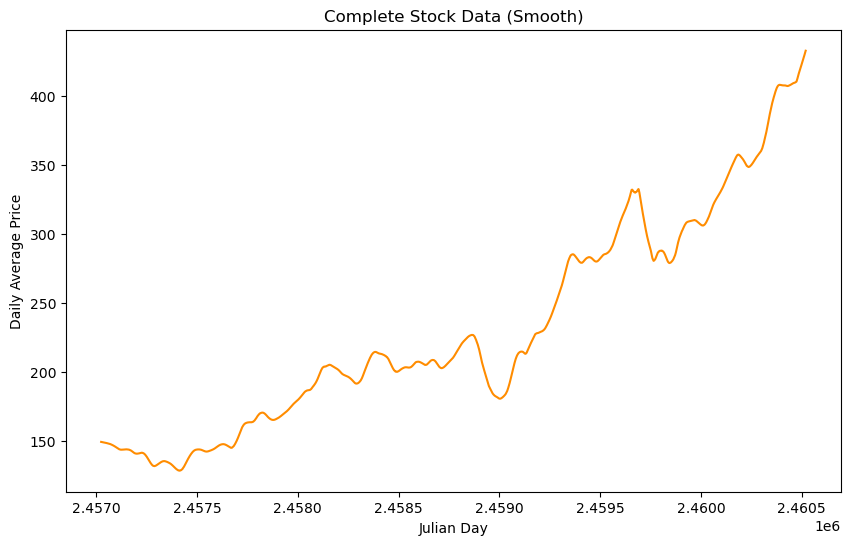

Best accuracy: Linear Regression at 0.956 with standard deviation of -1.000 and sample size of 2
Average performances:

	Decision Tree: 0.47881691342362664
	Random Forest: 0.5090732315623329
	Logistic Regression: 0.8768258684886302
	Linear Regression: 0.6947985559263824


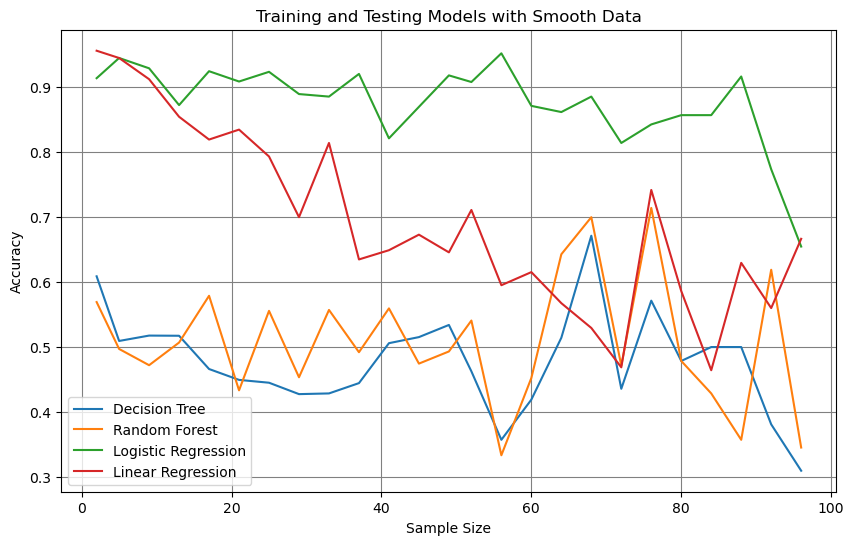

In [48]:
# 4.1 Generate smooth data
lowess = sm.nonparametric.lowess
smooth_data = lowess(prices, dates, frac=.025)
prices_smooth = list(zip(*smooth_data))[1]

# 4.2 Display smooth data
plt.figure(figsize=(10, 6))
plt.plot(dates, prices_smooth, color="darkorange")
plt.title("Complete Stock Data (Smooth)")
plt.xlabel("Julian Day")
plt.ylabel("Daily Average Price")
plt.show()

# 4.3 Train and evaluate models with smooth data
grid_optim(prices=prices_smooth, real_prices=prices_smooth, plot_title="Training and Testing Models with Smooth Data")

## 5. Explanation: Global Trends vs. Local Trends

As seen in the graph above, smoother data compliments the models much more than the noisey data from before. However, before training the models with smooth data and evaluating them with the realistic data, one ought to consider the reason for this increase in performance. There are two main explanations:

- The overall graph is almost always increasing, so the more consistent global trend may be giving an overly optimistic performance.
- The graph has much less noise, meaning that local trends are much more informative in predicting the label for each sample.

To determine which best explains the improved accuracies, a hypothetical stock will be generated with the sine function. The code block below generates this data and trains and evaluates the models with this data. The global trend of the graph is purely neutral, as the sine function has as many falls as it has rises. The local trend, however, is incredibly consistent due to the lack of noise.

**Task:**

1. Generate sine data
2. Display sine data
3. Train and evaluate models with sine data

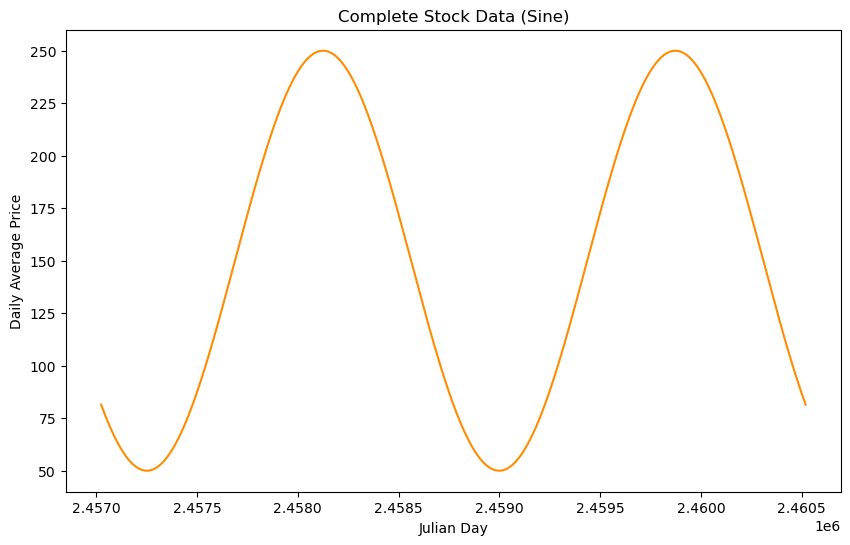

Best accuracy: Logistic Regression at 1.000 with standard deviation of 0.000 and sample size of 13
Average performances:

	Decision Tree: 0.6952877576050446
	Random Forest: 0.23957001912402368
	Logistic Regression: 0.9733325927651368
	Linear Regression: 0.9613935676264707


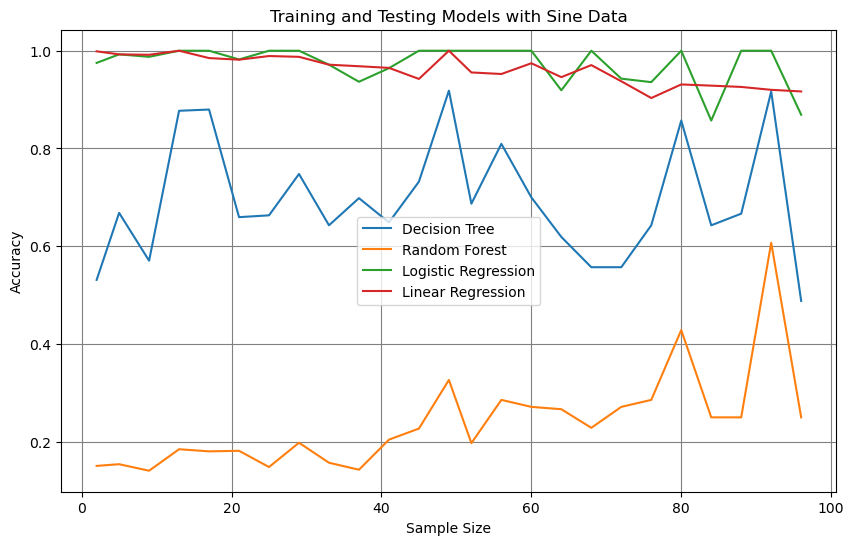

In [49]:
# 5.1 Generate sine data
lapse = dates[-1].item() - dates[0].item()
prices_sine = 100 * np.sin(dates / lapse * 4 * 3.14159265) + 150

# 5.2 Display sine data
plt.figure(figsize=(10, 6))
plt.plot(dates, prices_sine, color="darkorange")
plt.title("Complete Stock Data (Sine)")
plt.xlabel("Julian Day")
plt.ylabel("Daily Average Price")
plt.show()

# 5.3 Train and evaluate models with sine data
grid_optim(prices_sine, prices_sine, "Training and Testing Models with Sine Data")

## Final Optimization

The result from the previous code block boasts high accuracy values as before, meaning that the global trend does not affect the performance of the models. Instead, the predictive days in each sample must be incredibly informative due to the more consistent local trends.

These findings encourage the use of stock price smoothing as a form of feature extraction for the classification problem at hand. This can only be tested with a final grid optimization that determines the best smoothness for training models with smooth data and evaluating them with raw data. The code block below implements this by testing five different smoothness values.

**Task:**

<ol>
    <li>Display smooth data with a convenient function</li>
    <li>Iterate through each smoothness value</li>
    <ol>
        <li>Generate smooth data</li>
        <li>Plot smooth data and evaluate models</li>
    </ol>
</ol>

Computing smoothness = 0.1


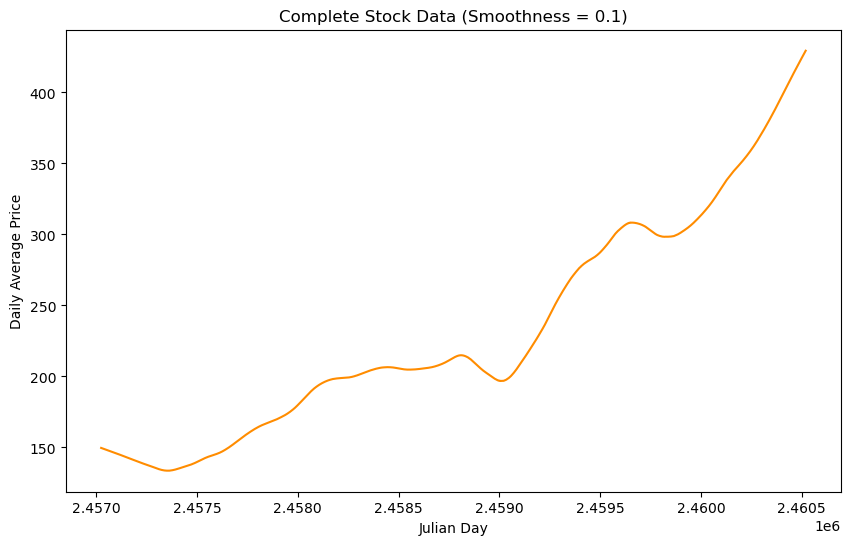

Best accuracy: Decision Tree at 0.750 with standard deviation of 0.189 and sample size of 84
Average performances:

	Decision Tree: 0.49629516101072646
	Random Forest: 0.5077328957513801
	Logistic Regression: 0.5059915577664142
	Linear Regression: 0.5545049109689317


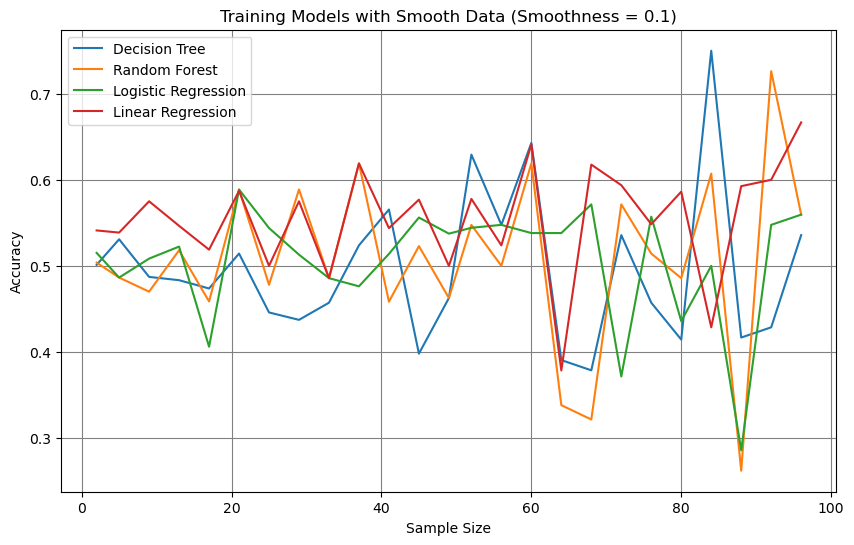





Computing smoothness = 0.05


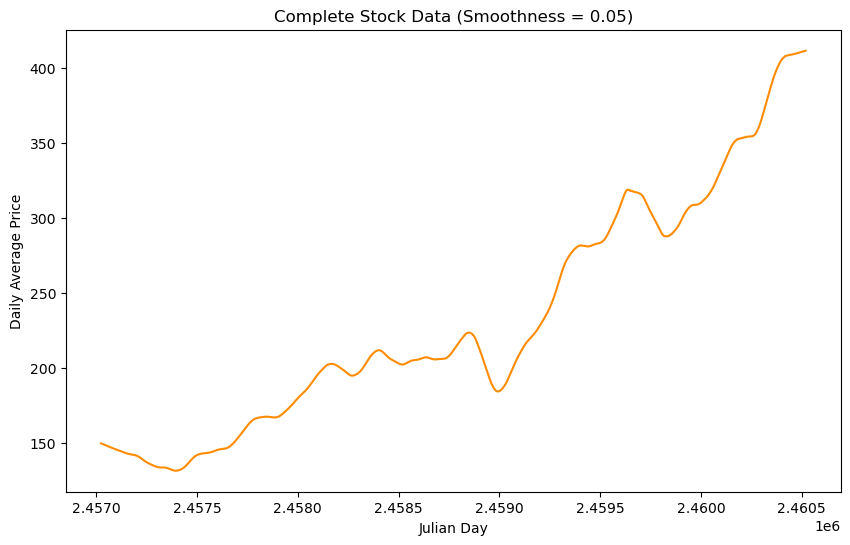

Best accuracy: Logistic Regression at 0.750 with standard deviation of 0.173 and sample size of 96
Average performances:

	Decision Tree: 0.5160358793076147
	Random Forest: 0.5107796191341429
	Logistic Regression: 0.5002293787459915
	Linear Regression: 0.5479457530145865


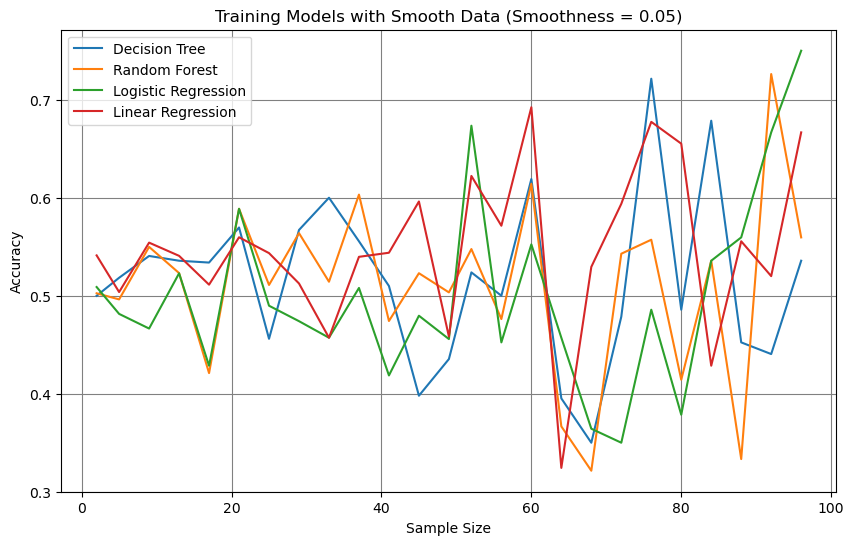





Computing smoothness = 0.03


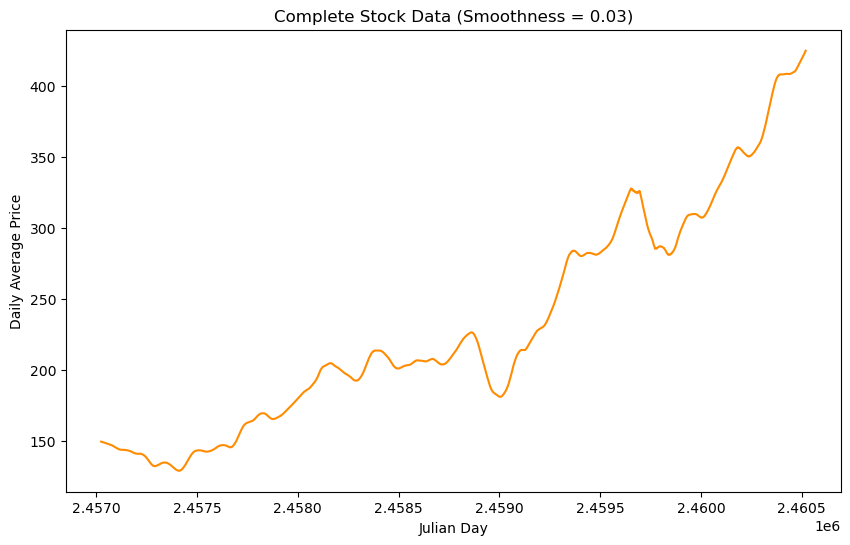

Best accuracy: Logistic Regression at 0.714 with standard deviation of 0.247 and sample size of 84
Average performances:

	Decision Tree: 0.4895889907758057
	Random Forest: 0.5002352041049815
	Logistic Regression: 0.5196793960223056
	Linear Regression: 0.5437931439967607


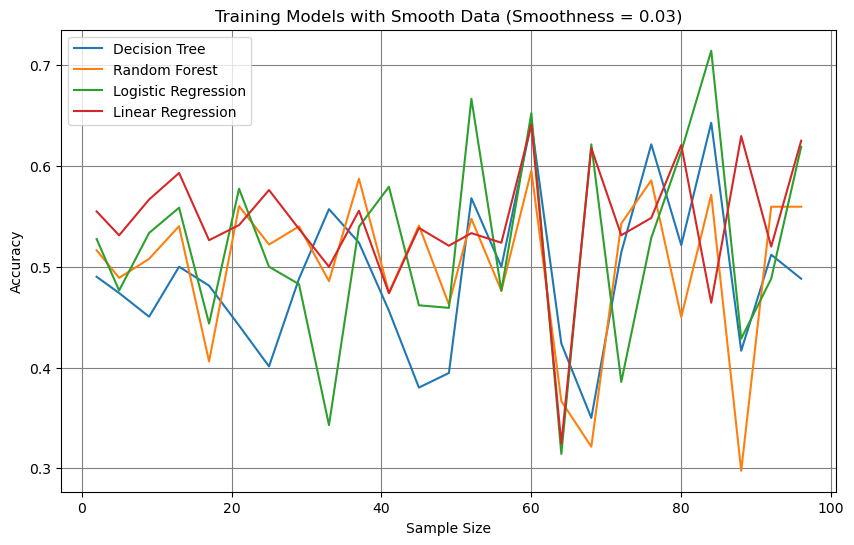





Computing smoothness = 0.01


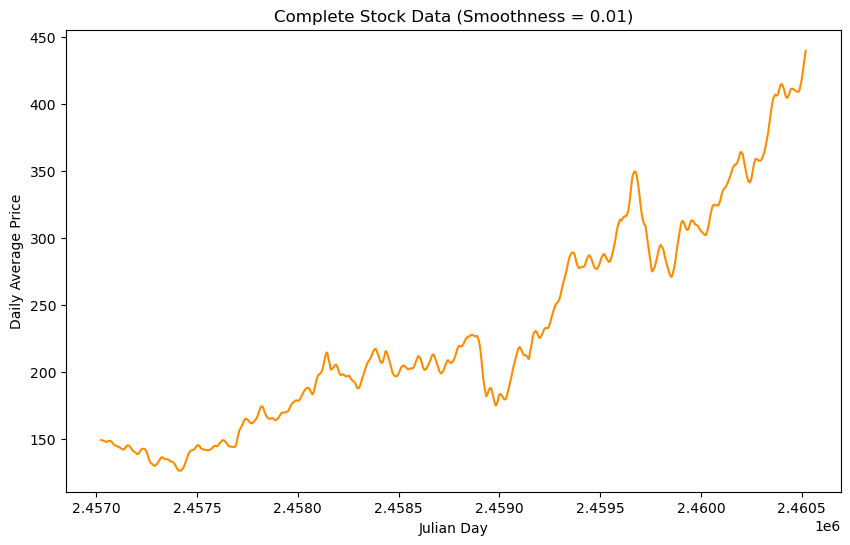

Best accuracy: Logistic Regression at 0.714 with standard deviation of 0.097 and sample size of 60
Average performances:

	Decision Tree: 0.501013846114065
	Random Forest: 0.4904120789357883
	Logistic Regression: 0.5573348008131799
	Linear Regression: 0.5415286702043695


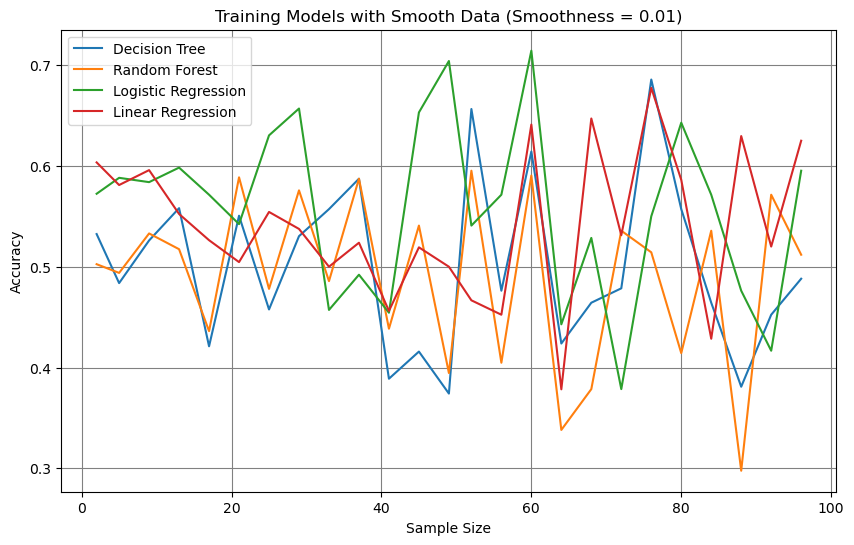





Computing smoothness = 0.005


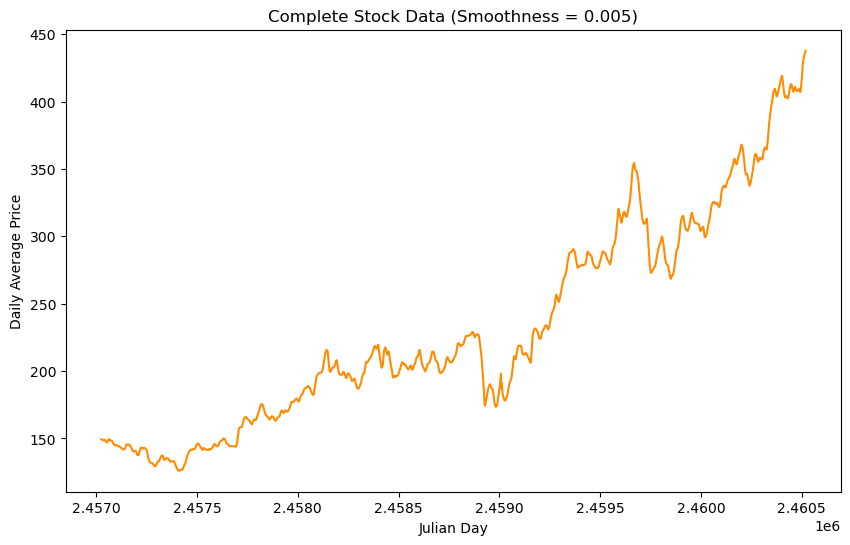

Best accuracy: Linear Regression at 0.742 with standard deviation of -1.000 and sample size of 76
Average performances:

	Decision Tree: 0.49624564501735446
	Random Forest: 0.49210022164205386
	Logistic Regression: 0.5747448231334455
	Linear Regression: 0.5481610287424374


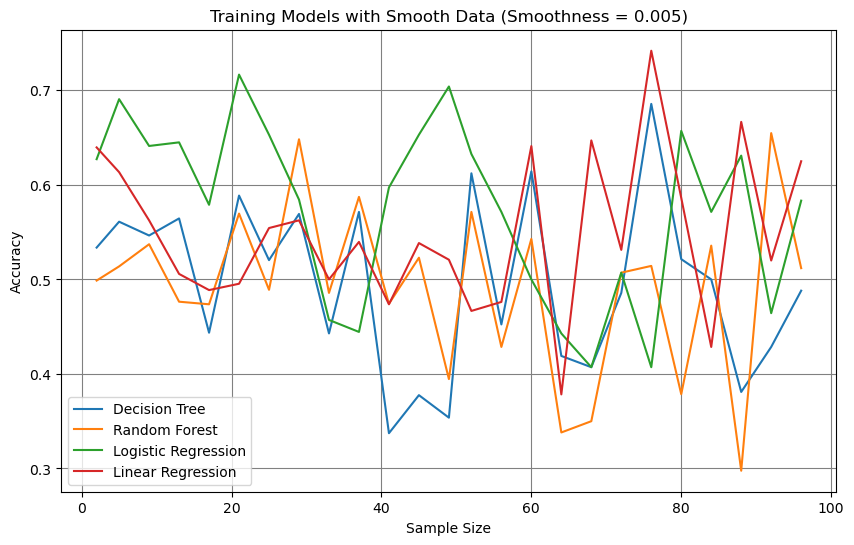

In [50]:
# 6.1 Display smooth data with a convenient function
def showSmoothData(prices_smooth: np.ndarray, smoothness: float):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, prices_smooth, color="darkorange")
    plt.title(f"Complete Stock Data (Smoothness = {smoothness})")
    plt.xlabel("Julian Day")
    plt.ylabel("Daily Average Price")
    plt.show()


# 6.2 Iterate through each smoothness value
smoothList = [.1, .05, .03, .01, .005]
for smoothFrac in smoothList:
    # 6.2.1 Generate smooth data
    smooth_data = lowess(prices, dates, frac=smoothFrac)
    prices_smooth = list(zip(*smooth_data))[1]
    if (smoothFrac != smoothList[0]): print("\n\n\n")

    # 6.2.2 Plot smooth data and evaluate models
    print(f"Computing smoothness = {smoothFrac}")
    showSmoothData(prices_smooth, smoothFrac)
    grid_optim(prices_smooth, prices, f"Training Models with Smooth Data (Smoothness = {smoothFrac})")

## 7. The OCAI Model

While the first few iterations did not suggest a boost in performance after smoothing prices, the last two (especially the last one) did. The final graph boasts a logistic regression model with an accuracy of almost 70% using only five predictive days per sample! Sections 4 and 5 also depict logistic regression as being more robust than the custom logistic regression classifier, suggesting the final model ought to be logistic regression with a sample size of five and a smoothness value of `.005`.

However, all of the testing up until now has been using k-fold cross validation. For prediction future stocks, this is generally frowned upon due to the data leaks that come with it. So, the final evaluation will compare the k-fold cross validation performance with the non-shuffled prices performance.

**Task:**

1. Define hyperparameters
2. Generate smooth data and the corresponding `X` and `y` arrays
3. Evaluate the performance with k-fold cross validation
4. Print the k-fold cross validation results
5. Evaluate the performance with non-shuffled data
6. Print the performance with non-shuffled data
7. Plot the results

Logistic regression with 5 days to predict with and a smoothness fraction of 0.005 (K-Fold):

	Average accuracy of folds: 0.6906922478610319
	Standard deviation for accuracy of folds: 0.052497516487031236
	Confidence interval for model accuracy (95%): [0.5709987391110739, 0.8103857566109899]


Logistic regression with 5 days to predict with and a smoothness fraction of 0.005 (Not K-Fold):

	Accuracy: 0.6446280991735537
	Confidence interval for model accuracy (95%): [0.5206830843159541, 0.7685731140311532]


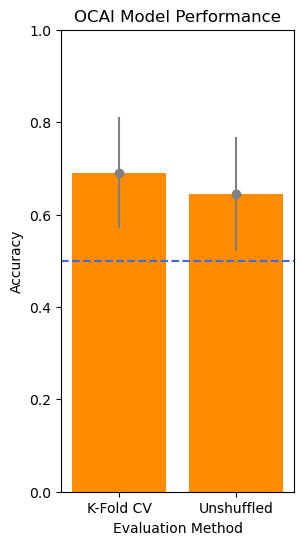

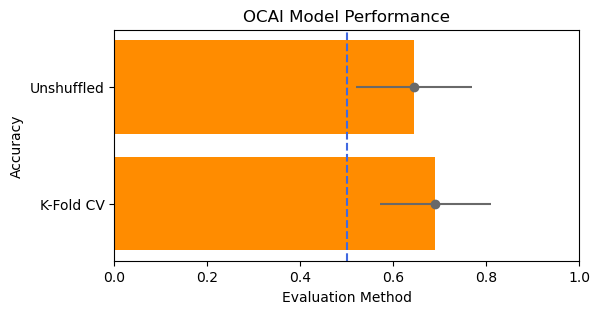

In [68]:
# 7.1 Define hyperparameters
RANDOM_STATE = 42
SAMPLE_SIZE = 5
NUM_SPLITS = 7
TEST_SIZE = .3
SMOOTHNESS_FRAC = .005

# 7.2 Generate smooth data and the corresponding X and y arrays
smooth_data = lowess(prices, dates, frac=SMOOTHNESS_FRAC)
prices_smooth = list(zip(*smooth_data))[1]
logReg = LogisticRegression(random_state=RANDOM_STATE)
X, y = createXY(prices_smooth, prices, 5)
accs = []
stderrs = []

# 7.3 Evaluate the performance with k-fold cross validation
stats_logReg = cross_val_score(logReg, X, y, scoring='accuracy', cv=KFold(n_splits=7), n_jobs=-1)
mean_acc = np.mean(stats_logReg)
accs.append(mean_acc)
std_err = sqrt(mean_acc * (1 - mean_acc) / (y.shape[0] / NUM_SPLITS))
stderrs.append(1.96 * std_err)

# 7.4 Print the k-fold cross validation results
print(f"Logistic regression with {SAMPLE_SIZE} days to predict with and a smoothness fraction of {SMOOTHNESS_FRAC} (K-Fold):\n")
print(f"\tAverage accuracy of folds: {mean_acc}")
print(f"\tStandard deviation for accuracy of folds: {np.std(stats_logReg)}")
print(f"\tConfidence interval for model accuracy (95%): [{mean_acc - 1.96 * std_err}, {mean_acc + 1.96 * std_err}]")

# 7.5 Evaluate the performance with non-shuffled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)
logReg.fit(X_train, y_train)
mean_acc = accuracy_score(y_test, logReg.predict(X_test))
accs.append(mean_acc)
std_err = sqrt(mean_acc * (1 - mean_acc) / (y.shape[0] / NUM_SPLITS))
stderrs.append(1.96 * std_err)

# 7.6 Print the performance with non-shuffled data
print(f"\n\nLogistic regression with {SAMPLE_SIZE} days to predict with and a smoothness fraction of {SMOOTHNESS_FRAC} (Not K-Fold):\n")
print(f"\tAccuracy: {mean_acc}")
print(f"\tConfidence interval for model accuracy (95%): [{mean_acc - 1.96 * std_err}, {mean_acc + 1.96 * std_err}]")

# 7.7 Plot the results
contexts = ["K-Fold CV", "Unshuffled"]
plt.figure(figsize=(3, 6))
plt.bar(contexts, accs, color="darkorange")
plt.errorbar(contexts, accs, yerr=stderrs, fmt="o", color="gray")
plt.axhline(y=0.5, linestyle='--', color="royalblue")
plt.title("OCAI Model Performance")
plt.xlabel("Evaluation Method")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.show()

plt.figure(figsize=(6, 3))
plt.barh(contexts, accs, color="darkorange")
plt.errorbar(accs, contexts, xerr=stderrs, fmt="o", color="dimgray")
plt.axvline(x=.5, linestyle='--', color="royalblue")
plt.title("OCAI Model Performance")
plt.xlabel("Evaluation Method")
plt.ylabel("Accuracy")
plt.xlim([0, 1])
plt.show()

## 8. Results

The OCAI model performs better than a coin flip, even at the lower bound of the confidence interval! Given the simplicity of the models used in this study, an average accuracy of .65 is noteworthy.

## 9. Distribution of Work 

Evan worked on the notebook code, and Beatrice, Evan and Isaac worked on the presentation. Beatrice did the Abstract, Methodology, and Lessons Learned; Evan did the Motivation and Results; Isaac did the Modern Models, Acknowledgements and References. 